# Image Encryption and Decryption using bit-level Permutation

In [1]:
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import random

Function to get Image matrix from Pixel Access object

In [2]:
# Load image and convert to grayscale
img = Image.open('misc/4.1.03.tiff').convert("L")

# Convert image to numpy array
img_array = np.array(img)

# Display data type of image
print("Data type of image:", img_array.dtype)

Data type of image: uint8


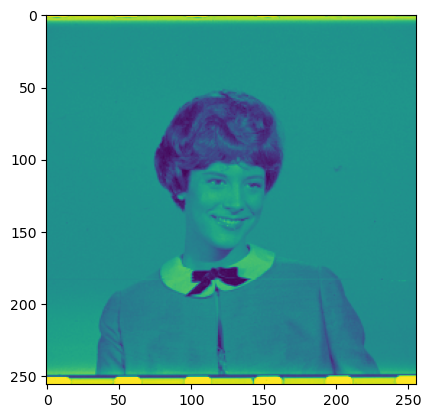

In [3]:
plt.imshow(img_array)

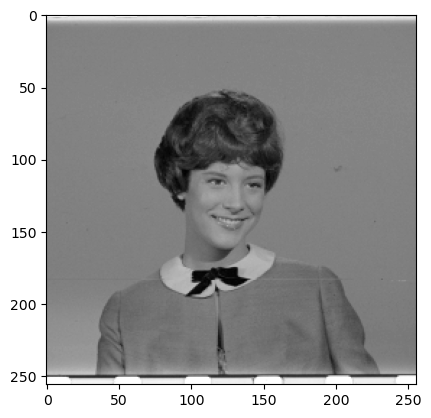

In [4]:
plt.imshow(img_array, cmap='gray')

Showing Image with Histogram

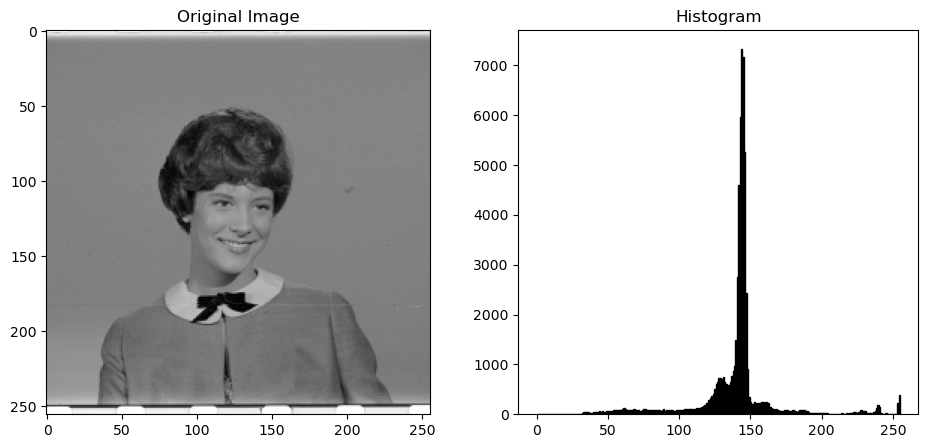

In [5]:
plt.subplots_adjust(bottom=0.2, right=1.5,  top=1)
plt.subplot(1,2,1)
plt.title("Original Image")
plt.imshow(img_array,cmap='gray')

plt.subplot(1,2,2)
plt.title("Histogram")
plt.hist(img_array.ravel(), bins=256, range=(0,255), fc='k', ec='k')
plt.show()

In [6]:
# getting image height and width
height = img_array.shape[0]
width = img_array.shape[1]
print("height: {}, width: {}".format(height, width))

height: 256, width: 256


# Conversions

In [7]:
from math import log2
from copy import copy as cpy
def image_entropy(pic):
    # Compute histogram of pixel intensities
    hist, _ = np.histogram(pic, bins=256, range=(0, 255))
    
    # Normalize histogram to sum to 1
    hist = hist / np.sum(hist)
    
    # Compute entropy
    entropy = -np.sum(p * np.log2(p) for p in hist if p > 0)
    
    return entropy
def decToBin(value):
    return str(bin(value).replace("0b","")).zfill(4)

def binToDec(value):
    return int(str(value),2)

def scaleTo255(image):
    # Scale a binary image to grayscale image of level (0-255)
    gray_img = 255 - image.astype('uint8') * 255
    return gray_img


def binToGray(image, height, width):
    
     # Create empty grayscale image
    gray_img = np.zeros((height, width), dtype=np.uint8)

     #Replace white pixels with 255 (black in grayscale)
    gray_img[np.where(img == 1)] = 255

def horizontal_adjacent(img, height, width):
    # Shift image horizontally by one pixel
    shifted_img = np.roll(img, 1, axis=1)
    
    # Concatenate original and shifted image horizontally
    adjacent_img = np.concatenate((img, shifted_img[:, :1]), axis=1)
    
    return adjacent_img




# Decomposing Image into various Planes and Generating Cipher Image

In [8]:
# Function for bitplane decomposition from the original image
def bitplane_decomposition(img, height, width):
    img = np.asarray(img)
    # Initialize list of bit-planes
    n_bits = 8
    bitplanes = [np.zeros_like(img) for i in range(n_bits)]
    
    # Perform bit-plane decomposition
    for i in range(n_bits):
        bitplanes[i] = (img >> i) & 1
    
    return bitplanes


    

def bitmapToCipher_composition(img, height, width):
    final = []

    # combining process
    for i in range(7):
        if i==0:
            for j in range(height):
                temp = []
                for k in range(width):
                    temp.append(int(str(bitplane_images[i][j][k])+str(bitplane_images[i+1][j][k])))
                final.append(temp)
        else:
            for j in range(height):
                temp = []
                for k in range(width):
                    temp.append(int(str(final[j][k])+str(bitplane_images[i+1][j][k])))
                final[j] = temp

    # converting binary pixels to decimal
    for i in range(height):
        for j in range(width):
            final[i][j] = binToDec(final[i][j])
    return np.array(final, dtype=np.uint8)

# Performing Bitplanes Decomposition

In [9]:
bitplane_images = bitplane_decomposition(img_array, height, width)
titles = ['bitplane8',
          'bitplane7',
          'bitplane6',
          'bitplane5',
          'bitplane4',
          'bitplane3',
          'bitplane2',
          'bitplane1']

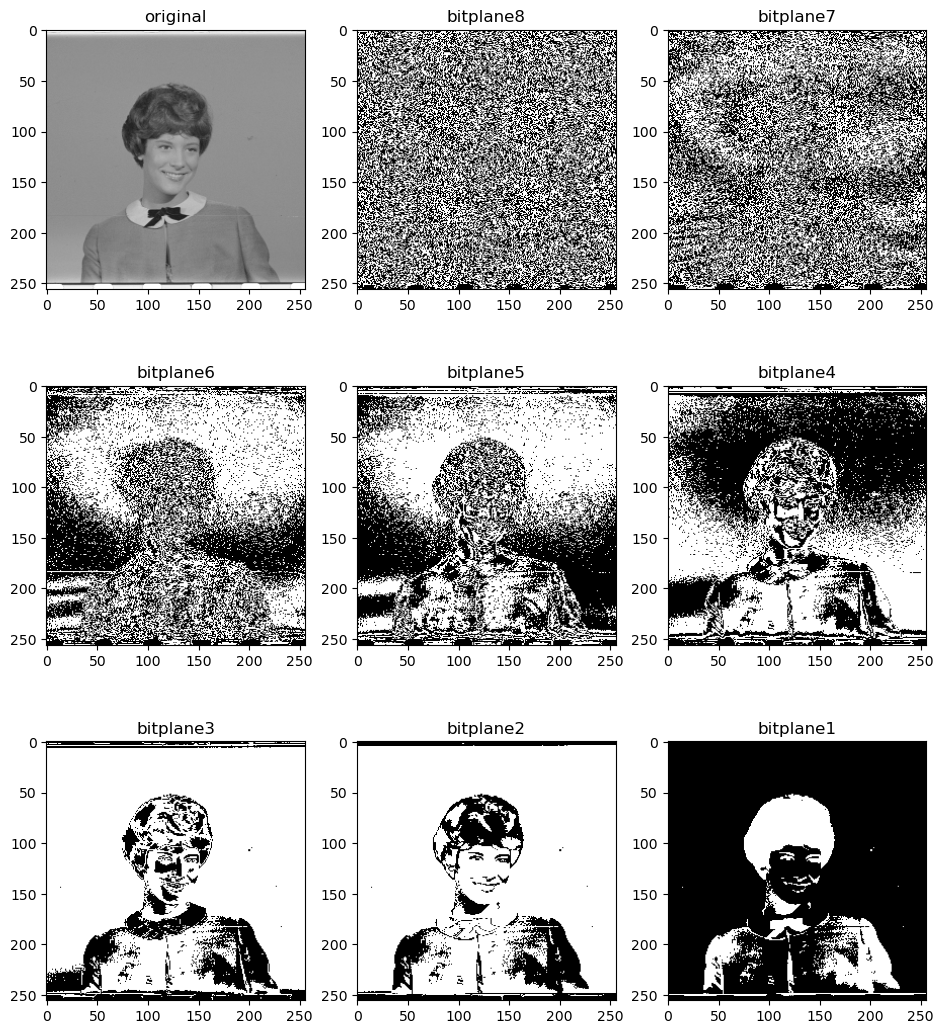

In [10]:
# viewing bitplane images
plt.subplot(3,3,1)
plt.title('original')
plt.imshow(img_array, cmap='gray', vmin=0, vmax=255)

for i in range(8):
    plt.subplot(3,3,i+2)
    plt.title(titles[i])
    plt.imshow(scaleTo255(bitplane_images[i]), cmap='gray', vmin=0, vmax=255)

plt.subplots_adjust(bottom=0.1, right=1.5, top=2.2)

In [11]:


class PRNG:                                   # Pseudo random number generator
    def __init__(self, init, alpha = 0.4):    # constructor
        ''' Pseudo random number generator
        alpha and init value must not same value
        Parameters : alpha (double) : system parameter : default = 0.4
                     init (double) : system parameter '''
        self.alpha = alpha                      # 'alpha' and 'init' are system parameter and initial condition of the map respectively
        self.init = init 
    
    def generate(self):                         # generator class
        ''' Generate a single number in floating point between 0 to 1
        typically generate next value of X(i+1) in the series by using previous value of X(i) and upadate it
        Parameters : None
        Returns : self.init (double) : a random number between 0 to 1 '''
        if self.init > self.alpha:
            self.init = ((1 - self.init)/(1 - self.alpha))
        else:
            self.init = (self.init / self.alpha)
        return self.init 

class CCCBG:                                    # Cross-Coupled Chaotic random Bit Generator
    def __init__(self, x0 = 0.5, y0 = 0.7):     # constractor
        ''' Cross-Coupled Chaotic random Bit Generator 
        two skew tent maps which are piecewise linear chaotic maps and cross-coupled
        Parameters : x0 (double) : initial value of 1st tent map : default = 0.5
                     y0 (double) : initial value of 2nd tent map : default = 0.7 '''
        self.fx = PRNG(init = x0)               # for dynamic system parameters
        self.fy = PRNG(init = y0)
    
    def generateBit(self):                      # single random binary bit generator
        ''' A single random binary bit generator
        Returns: {0,1} : based on the X(i+1) value of the sequence '''
        if self.fx.generate() < self.fy.generate():
            return 1
        return 0
    
    def generateMatrix(self, height, width):    # pseudo random binary matrix generator
        ''' Generate a pseudo random binary matrix of height X width
        Parameters: height (int) : height of the original image
                    width (int) : width of the original image
        Returns: mat (numpy array) : random binary matrix '''
        mat = []                                # height X width binary matrix
        for i in range(height):
            temp = []
            for j in range(width):
                temp.append(self.generateBit())
            mat.append(temp)
        return np.array(mat, dtype=np.uint8)

# Cipher Image Generation

In [12]:
# CCCBG
diffusion_range = 5
cccbg = CCCBG(.5, .7)

mats = []
for i in range(diffusion_range):
    bitplane_images[i] = cv2.bitwise_xor(cccbg.generateMatrix(height, width), bitplane_images[i])
    mats.append(cccbg.generateMatrix(height, width))

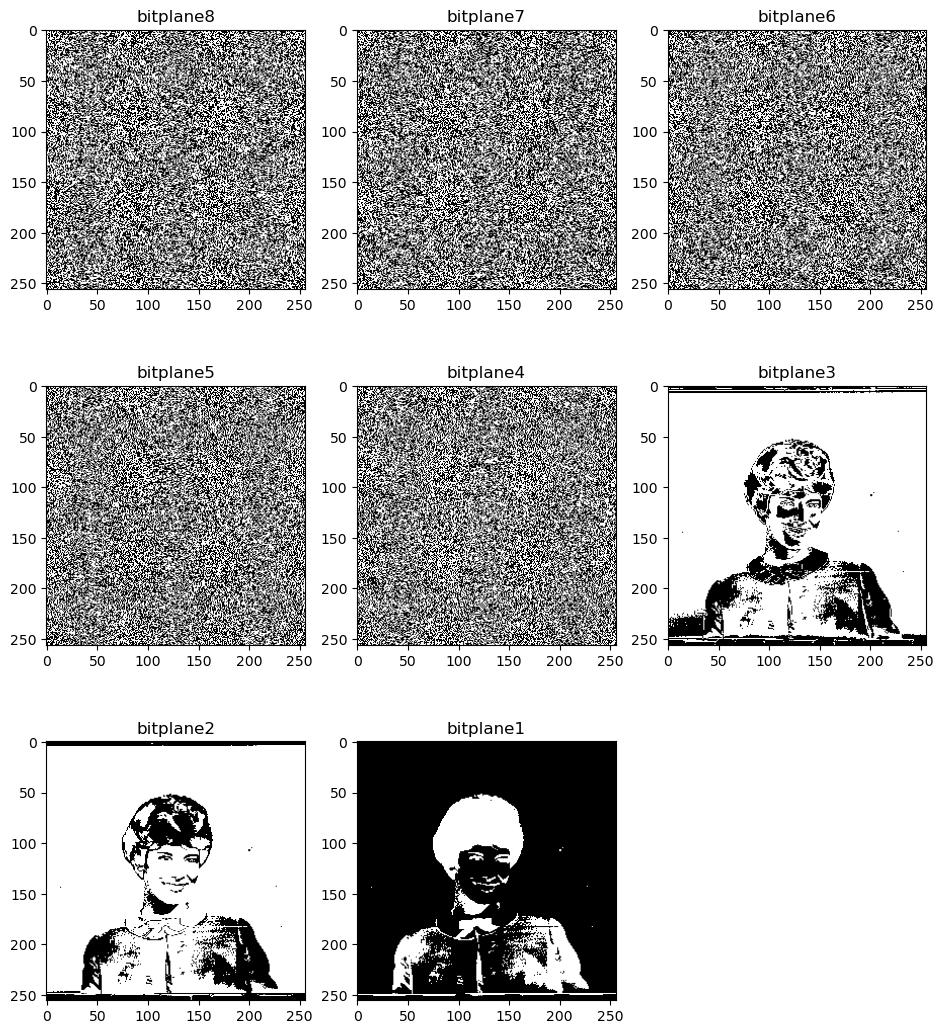

In [13]:
# viewing bitplane images
for i in range(8):
    plt.subplot(3,3,i+1)
    plt.title(titles[i])
    plt.imshow(scaleTo255(bitplane_images[i]), cmap='gray', vmin=0, vmax=255)
plt.subplots_adjust(bottom=0.1, right=1.5, top=2.2) 

True

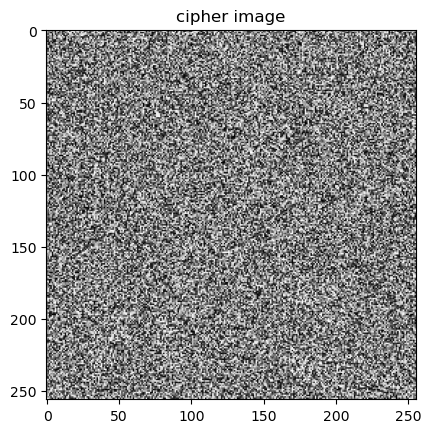

In [14]:
cipher_image = bitmapToCipher_composition(bitplane_images, height, width)
plt.title('cipher image')
plt.imshow(cipher_image, cmap='gray')

cv2.imwrite('cipherImage.tiff', cipher_image)

# Analysis of Experimentation

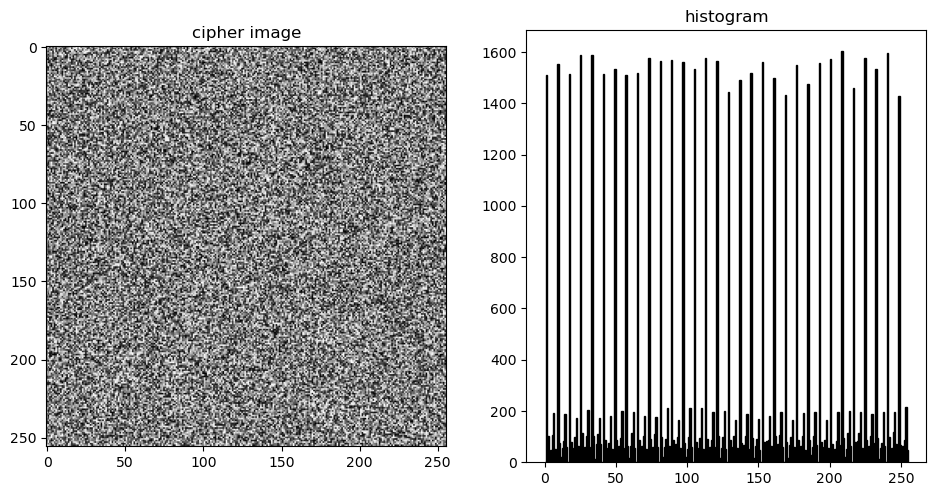

In [15]:
# histogram analysis
plt.subplots_adjust(bottom=0.1, right=1.5, top=1)

plt.subplot(1,2,1)
plt.title('cipher image')
plt.imshow(cipher_image, cmap='gray', vmin=0, vmax=255)

plt.subplot(1,2,2)
plt.title('histogram')
plt.hist(cipher_image.ravel(), bins=256, range=(0, 255), fc='k', ec='k')

plt.show()

# Measures of Central Tendency and Dispersion

In [16]:
print("Mean original: {}".format(np.mean(img)))
print("Mean cipher: {}".format(np.mean(cipher_image)))

Mean original: 139.72193908691406
Mean cipher: 125.86564636230469


In [17]:
print("Median original: {}".format(np.median(img)))
print("Median cipher: {}".format(np.median(cipher_image)))

Median original: 143.0
Median cipher: 126.0


In [18]:
print("Standard Derivation of original: {}".format(np.std(img)))
print("Standard Derivation of cipher: {}".format(np.std(cipher_image)))

Standard Derivation of original: 29.682123766893504
Standard Derivation of cipher: 73.94722144263021


In [19]:
from math import log10, sqrt
import random

def MSE(img_org, compressed_img, size):
    a = abs(np.subtract(img_org,compressed_img))
    b = 0
    for i in a:
        for j in i:
            b += (j**2)
    return b/(size[0]*size[1])

def PSNR(img_org, compressed_img,mse):
        mse = np.mean((img_org - compressed_img) ** 2)
        if(mse == 0):   # MSE is zero means no noise is present in the signal .
            return 100
        max_pixel = 255.0
        psnr = 20 * log10(max_pixel / sqrt(mse))
        return 
    
    

# Scatter Plot Analysis

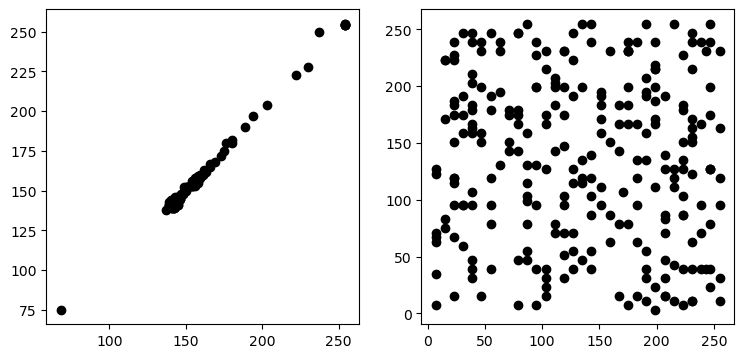

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(5, 3.5))
fig.subplots_adjust(bottom=0.1, right=1.5, top=1)
ax[0].scatter(img_array[:, 0],img_array[:, 1],color='black')
ax[1].scatter(cipher_image[0,],cipher_image[1,],color='black')
plt.show()

# Entropy

In [21]:
# calculate entropy of the image
print('Entropy of the original image: {:.2f}'.format(image_entropy(img)))
print('Entropy of the cipher image: {:.2f}'.format(image_entropy(cipher_image)))

Entropy of the original image: 5.59
Entropy of the cipher image: 6.39


C:\conda_tmp\ipykernel_8204\81290223.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  entropy = -np.sum(p * np.log2(p) for p in hist if p > 0)


# Measurements

In [22]:
mse = MSE(img, cipher_image, img_array.shape)
psnr = PSNR(img, cipher_image, mse)
print("MSE: {} DB".format(mse))
print("PSNR: {} DB".format(psnr))

MSE: 21677.374755859375 DB
PSNR: None DB


In [23]:
# read an image file
img2 = cv2.imread('cipherImage.tiff', cv2.IMREAD_GRAYSCALE)
# img = cv.imread('test-images/miscellaneous/4.1.04.tiff', cv.IMREAD_GRAYSCALE)
print("Image document type is: {}".format(img2.dtype))
height = img2.shape[0]
width = img2.shape[1]

Image document type is: uint8


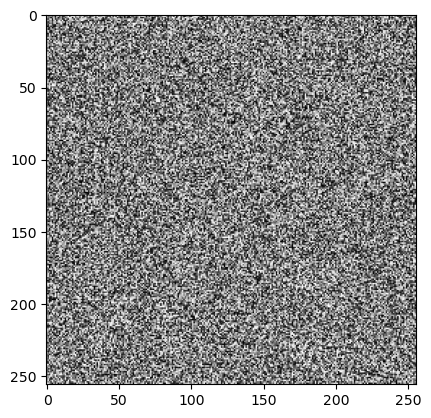

In [24]:
plt.imshow(img2, cmap='gray')

# Degradation Functions

In [25]:
# seed parameters for decryption
key = {
    'diffusion_range' : 5,
    'x0' : .5,
    'y0' : .7
}

In [26]:
# read an image file
img_received = cv2.imread('cipherImage.tiff', cv2.IMREAD_GRAYSCALE)
print("Image document type is: {}".format(img_received.dtype))
height = img_received.shape[0]
width = img_received.shape[1]

Image document type is: uint8


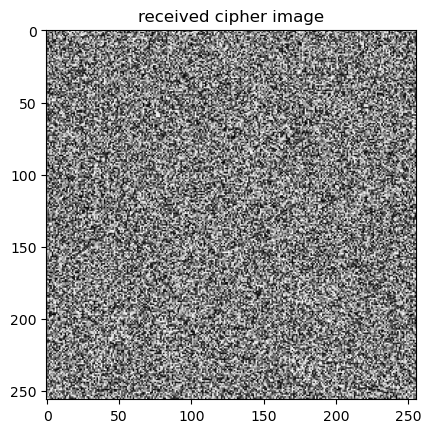

In [27]:
# plot image
plt.title('received cipher image')
plt.imshow(img_received, cmap='gray')

In [28]:
# obtaining bitplanes
bitplane_images = bitplane_decomposition(img_received, height, width)
titles = ['bitplane8',
          'bitplane7',
          'bitplane6',
          'bitplane5',
          'bitplane4',
          'bitplane3',
          'bitplane2',
          'bitplane1']

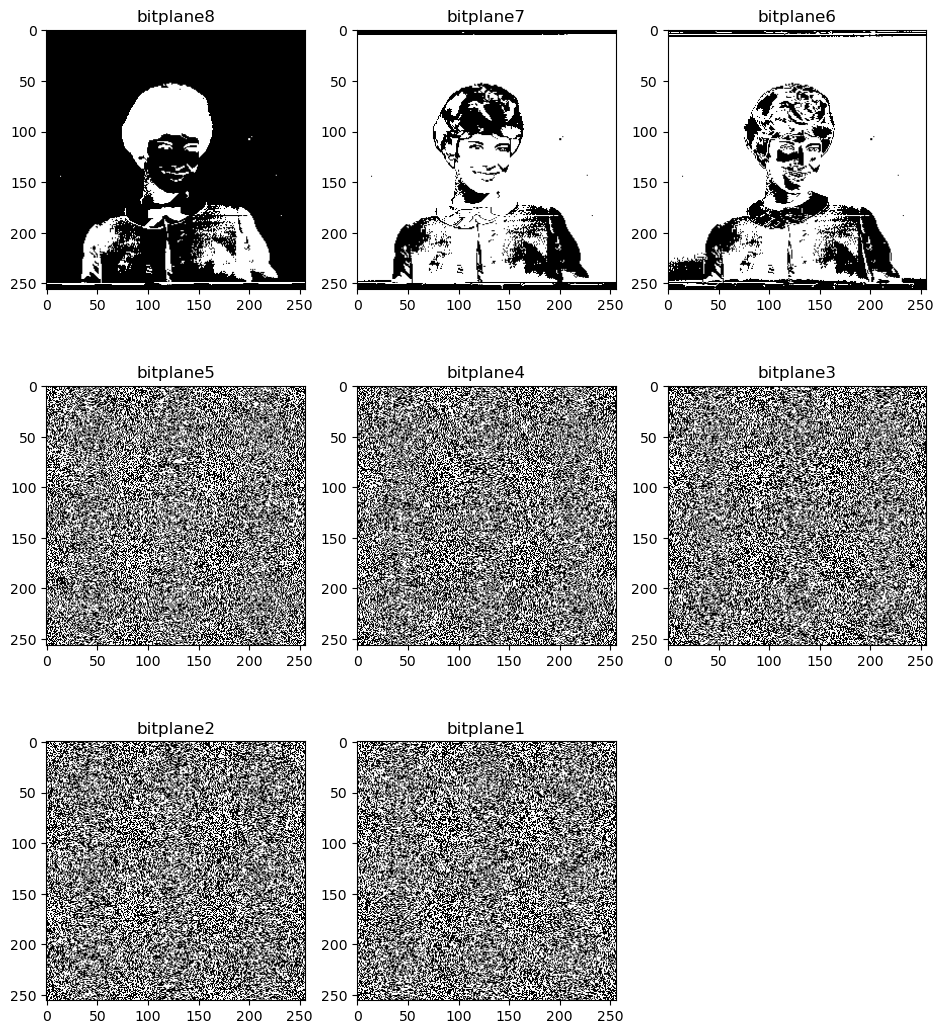

In [29]:
# viewing bitplane images
for i in range(8):
    plt.subplot(3,3,i+1)
    plt.title(titles[i])
    plt.imshow(scaleTo255(bitplane_images[i]), cmap='gray', vmin=0, vmax=255)

plt.subplots_adjust(bottom=0.1, right=1.5, top=2.2)

In [30]:
# CCCBG
cccbg = CCCBG(key['x0'], key['y0'])

mats = []
for i in range(key['diffusion_range']):
    bitplane_images[i] = cv2.bitwise_xor(cccbg.generateMatrix(height, width), bitplane_images[i])
    mats.append(cccbg.generateMatrix(height, width))

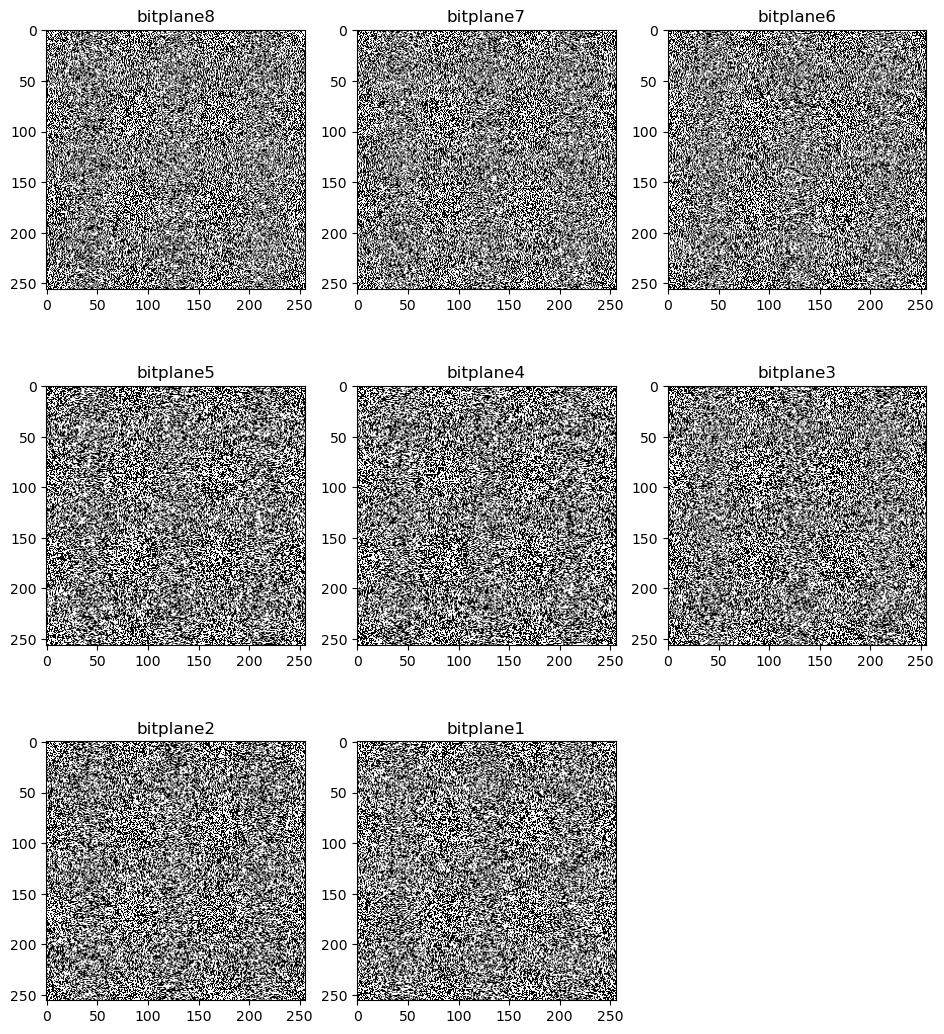

In [31]:
# viewing bitplane images
for i in range(8):
    plt.subplot(3,3,i+1)
    plt.title(titles[i])
    plt.imshow(scaleTo255(bitplane_images[i]), cmap='gray', vmin=0, vmax=255)

plt.subplots_adjust(bottom=0.1, right=1.5, top=2.2)


In [32]:
# CCCBG
cccbg = CCCBG(key['x0'], key['y0'])

mats = []
for i in range(key['diffusion_range']):
    bitplane_images[i] = cv2.bitwise_xor(cccbg.generateMatrix(height, width), bitplane_images[i])
    mats.append(cccbg.generateMatrix(height, width))

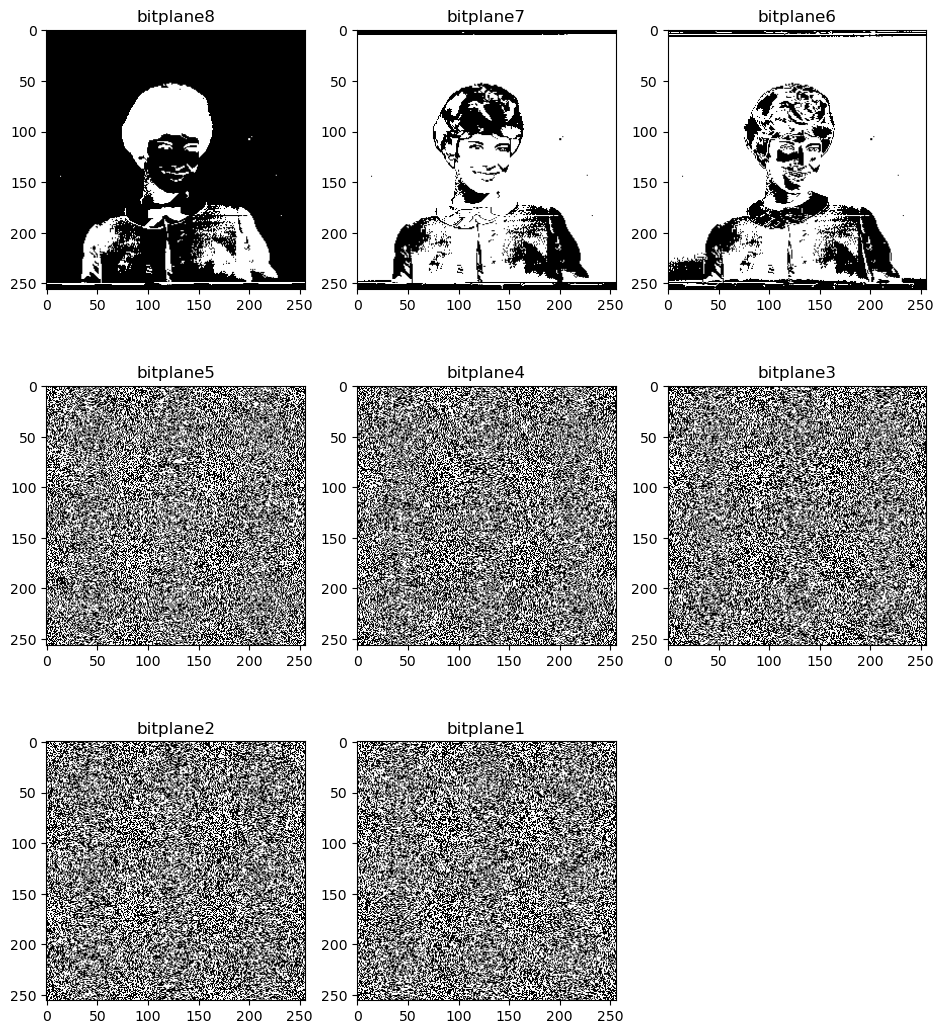

In [33]:
# viewing bitplane images
for i in range(8):
    plt.subplot(3,3,i+1)
    plt.title(titles[i])
    plt.imshow(scaleTo255(bitplane_images[i]), cmap='gray', vmin=0, vmax=255)

plt.subplots_adjust(bottom=0.1, right=1.5, top=2.2)


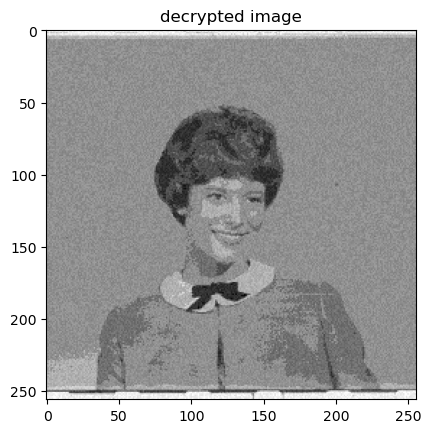

In [34]:
decrypted_img = bitmapToCipher_composition(bitplane_images, height, width)
plt.title('decrypted image')
plt.imshow(decrypted_img, cmap='gray')

In [35]:
# from statistics import median
# class Degreadation:
#     def __init__(self, img, height, width, row =3):
#         ''' constractor '''
#         self.img = img          # original image
#         self.height = height    # height of the original image
#         self.width = width      # width of the original image
#         self.row = row          # default row size

#     def _neighbour(self, xc, yc, Q=1):
#         ''' return a list of neighbour pixels '''
#         order_of_filter = Q 
#         nrow = int(self.row/2)
#         list = []
#         for a in range(-nrow, nrow+1):
#             for b in range(-nrow, nrow+1):
#                 x = xc+b 
#                 y = yc+a 
#                 if x >= 0 and x <= self.width-1 and y >= 0  and y <= self.height-1:   # if pixel range inside image matrix
#                     list.append(int(pow(self.img[x][y],order_of_filter)))
#         return list 
    
#     def medianFilter(self):
#         ''' median filter '''
#         degradated_img = self.img.copy()
#         for a in range(self.width):
#             for b in range(self.height):
#                 degradated_img[a][b] = int(median(self._neighbour(a,b)))

#         return np.array(degradated_img, dtype=np.uint8)

In [36]:
# degradation = Degreadation(decrypted_img, height, width)
# for i in range(6):
#     de_img = degradation.medianFilter()